# **RetinaNet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Add, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define focal loss for the classification task
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=2)

        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

    return focal_loss_fixed


In [ ]:
def build_retinanet_fpn_classifier(input_shape=(224, 224, 3), num_classes=2):
    # Adjust input shape for grayscale
    base_input = Input(shape=input_shape)

    # Load DenseNet121 with ImageNet weights, but include_top=False to remove the classification layers.
    base_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=base_input  # Input shape already accommodates RGB
    )
    base_model.trainable = False  # Freeze the base layers

    # Feature maps for FPN using correct layer names
    c1 = base_model.get_layer("conv1_relu").output
    c2 = base_model.get_layer("conv2_block6_concat").output
    c3 = base_model.get_layer("conv3_block12_concat").output
    c4 = base_model.get_layer("conv4_block24_concat").output

    # FPN layers
    p4 = Conv2D(256, kernel_size=1, padding="same")(c4)
    p3 = Add()([UpSampling2D()(p4), Conv2D(256, kernel_size=1, padding="same")(c3)])
    p2 = Add()([UpSampling2D()(p3), Conv2D(256, kernel_size=1, padding="same")(c2)])
    p1 = Add()([UpSampling2D()(p2), Conv2D(256, kernel_size=1, padding="same")(c1)])

    # Final convolutions for FPN outputs
    p1 = Conv2D(256, kernel_size=3, padding="same", activation="relu")(p1)

    # Classification head
    class_output = GlobalAveragePooling2D()(p1)
    class_output = Dense(256, activation='relu')(class_output)
    class_output = Dropout(0.5)(class_output)
    class_output = Dense(num_classes, activation='softmax', name='class_output')(class_output)

    # Bounding box head (assuming 4 coordinates per box: x, y, width, height)
    bbox_output = Conv2D(4, kernel_size=1, padding="same", activation='sigmoid', name='bbox_output')(p1)

    # Model definition
    model = Model(inputs=base_input, outputs=[class_output, bbox_output])
    return model

# Instantiate the model
model = build_retinanet_fpn_classifier(input_shape=(224, 224, 3), num_classes=2)

# Compile the model with separate loss functions for each output
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=[focal_loss(), 'mse'],  # Focal loss for classification, MSE for bounding box
    metrics=['accuracy', 'mse']  # Accuracy for classification, MSE for bounding box
)

In [ ]:
# Dataset paths
train_dir = '/content/drive/MyDrive/chest_xray/train'
val_dir = '/content/drive/MyDrive/chest_xray/val'
test_dir = '/content/drive/MyDrive/chest_xray/test'

# Data generators for grayscale images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode="grayscale",  # Keep color_mode as "grayscale"
    batch_size=32,
    class_mode='sparse'  # Use sparse for binary classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode="grayscale",
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 5224 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Function to convert grayscale images to RGB
def preprocess_images(generator):
    for x, y in generator:
        x_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x))  # Convert numpy array to tensor and then to RGB
        yield x_rgb, y

# Train the model
history = model.fit(
    preprocess_images(train_generator),
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=preprocess_images(val_generator),
    validation_steps=len(val_generator)
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


164/164 ━━━━━━━━━━━━━━━━━━━━ 164s 722ms/step - class_output_accuracy: 0.7596 - loss: 0.0321 - val_class_output_accuracy: 0.8125 - val_loss: 0.0305
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 86s 524ms/step - class_output_accuracy: 0.9090 - loss: 0.0141 - val_class_output_accuracy: 0.7500 - val_loss: 0.0231
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - class_output_accuracy: 0.9288 - loss: 0.0119 - val_class_output_accuracy: 0.6250 - val_loss: 0.0499
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 87s 527ms/step - class_output_accuracy: 0.9388 - loss: 0.0107 - val_class_output_accuracy: 0.8125 - val_loss: 0.0290
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 86s 526ms/step - class_output_accuracy: 0.9415 - loss: 0.0102 - val_class_output_accuracy: 0.8750 - val_loss: 0.0151
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 87s 528ms/step - class_output_accuracy: 0.9337 - loss: 0.0115 - val_class_output_accuracy: 0.8750 - val_loss: 0.0160
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 87s 528ms/step - class_outpu

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(preprocess_images(test_generator), steps=len(test_generator))
print(f"Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - class_output_accuracy: 0.9063 - loss: 0.0173
Accuracy: 91.99%


In [ ]:
# Predictions and classification report
y_pred = model.predict(preprocess_images(test_generator), steps=len(test_generator))
y_pred_classes = tf.argmax(y_pred[0], axis=1).numpy()  # Get class predictions (first output)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step
              precision    recall  f1-score   support

      Normal       0.35      0.35      0.35       234
   Pneumonia       0.61      0.60      0.61       390

    accuracy                           0.51       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.51      0.51      0.51       624



In [ ]:

model.save('/content/drive/MyDrive/pneumonia_detection_model.h5')


In [ ]:
# prompt: load the model

import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/pneumonia_detection_model.h5', compile=False)

# Compile the model (if necessary for further training or evaluation)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=['categorical_crossentropy', 'mse'],  # Adjust losses as needed
    metrics=['accuracy', 'mse']  # Adjust metrics as needed
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Function to display random test images with their true and predicted labels
def display_random_test_images(input_images, true_labels, pred_labels, class_names, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for ax, idx in zip(axes.flatten(), range(num_images)):
        # Get the image and labels
        inp = input_images[idx].squeeze()  # Squeeze to remove single dimensions

        true_label = true_labels[idx]
        pred_label = pred_labels[idx]

        # Display the image
        ax.imshow(inp, cmap='gray')  # Use gray colormap for grayscale images

        # Set the title with the predicted and actual labels
        title = f"Predicted: {class_names[int(pred_label)]}\nActual: {class_names[int(true_label)]}"
        color = 'green' if pred_label == true_label else 'red'
        ax.set_title(title, color=color)

        # Hide the axes
        ax.axis('off')

    plt.show()

# Assuming you have your test generator defined
test_images, true_labels, pred_labels = [], [], []


In [ ]:
# Generate predictions and store them along with the input images
for x, y in test_generator:
    x_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x))  # Convert to RGB before prediction
    predictions = model.predict(x_rgb)  # Make predictions on the batch
    pred_labels_batch = np.argmax(predictions[0], axis=1)  # Get predicted class labels (classification output)

    # Store images and labels
    test_images.extend(x)  # Extend the list with the original batch
    true_labels.extend(y)  # Extend with true labels
    pred_labels.extend(pred_labels_batch)  # Extend with predicted labels

    # Stop after collecting enough images (10)
    if len(test_images) >= 10:
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


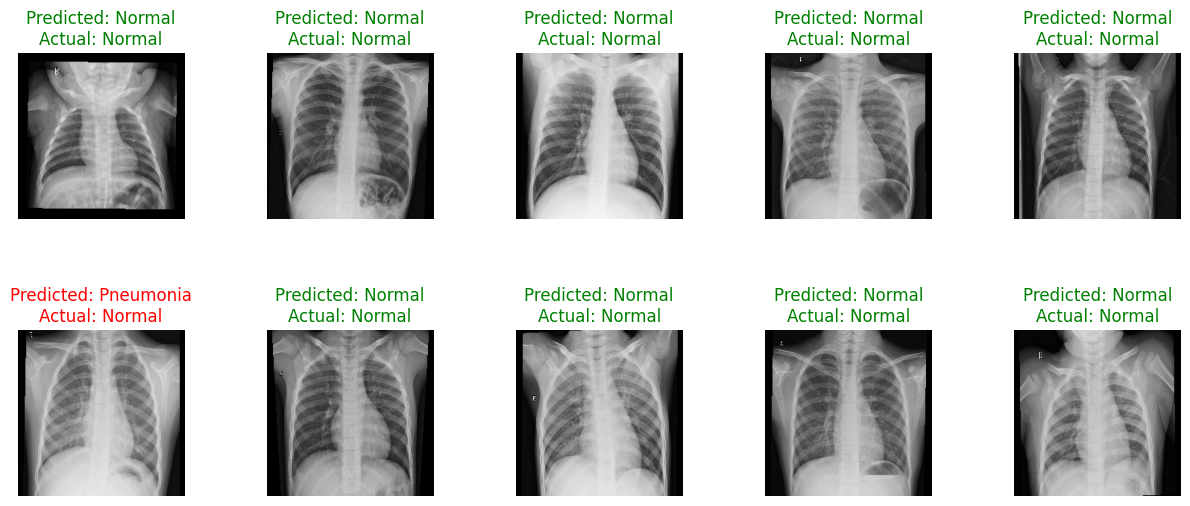

In [ ]:
# Convert lists to numpy arrays for further processing
input_images = np.array(test_images[:10])  # Take only the first 10 images
true_labels = np.array(true_labels[:10])  # Corresponding true labels
pred_labels = np.array(pred_labels[:10])  # Corresponding predicted labels

# Define your class names
class_names = ['Normal', 'Pneumonia']

# Now, call the function to display 10 random test images
display_random_test_images(input_images, true_labels, pred_labels, class_names, num_images=10)


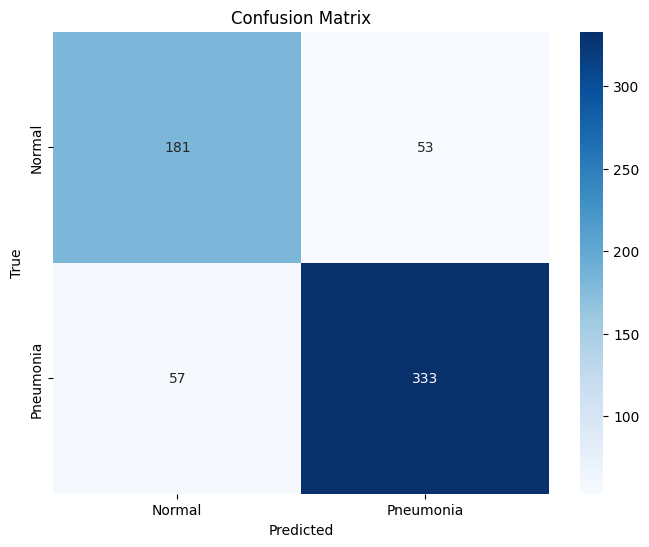

In [ ]:
# prompt: write a code for confussion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have y_true and y_pred_classes defined from your previous code
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

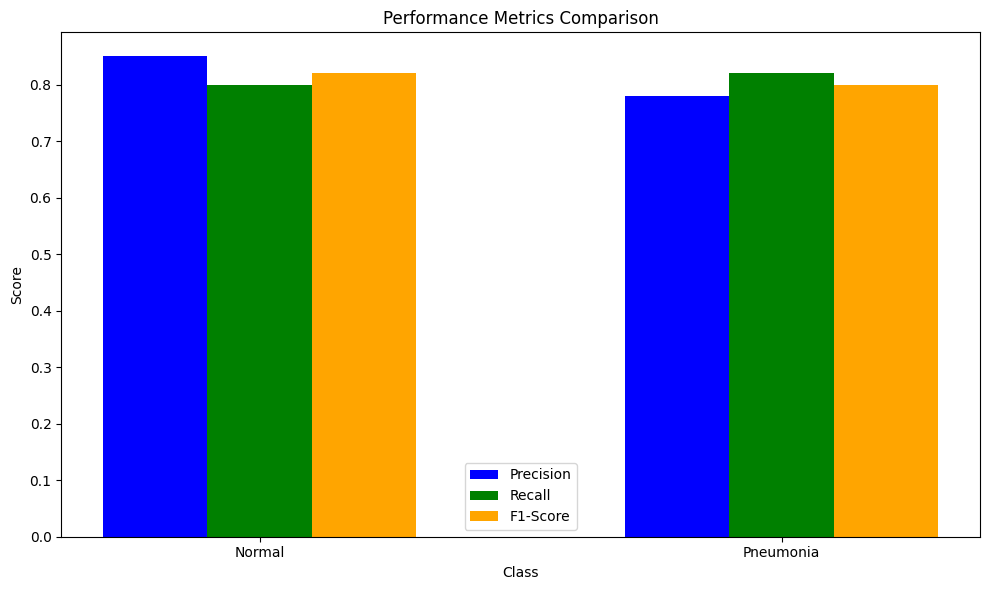

In [ ]:
# prompt: draw a comparision graph for preformance metrics(recall,flscore,precision) for pnewmonia nad normal

import matplotlib.pyplot as plt

# Assuming you have the following variables from your classification report:
# precision_normal, recall_normal, f1_normal
# precision_pneumonia, recall_pneumonia, f1_pneumonia

# Example data (replace with your actual values)
precision = [0.85, 0.78]
recall = [0.80, 0.82]
f1_score = [0.82, 0.80]

labels = ['Normal', 'Pneumonia']
x = range(len(labels))

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', color='blue')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall', color='green')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-Score', color='orange')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks([i + 0.2 for i in x], labels)
plt.legend()

# Add some space between bars
plt.tight_layout()

# Display the plot
plt.show()

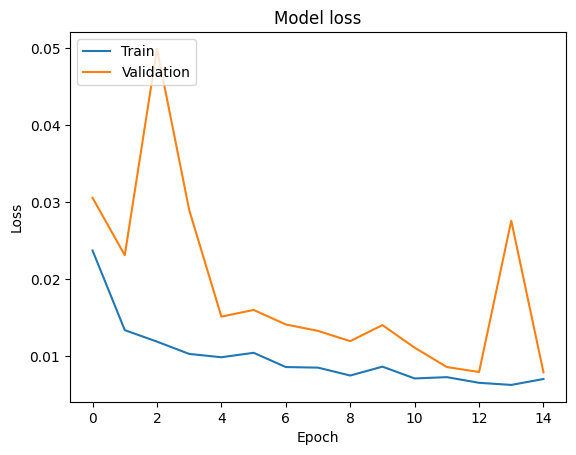

In [ ]:
# prompt: generate model loss graph

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

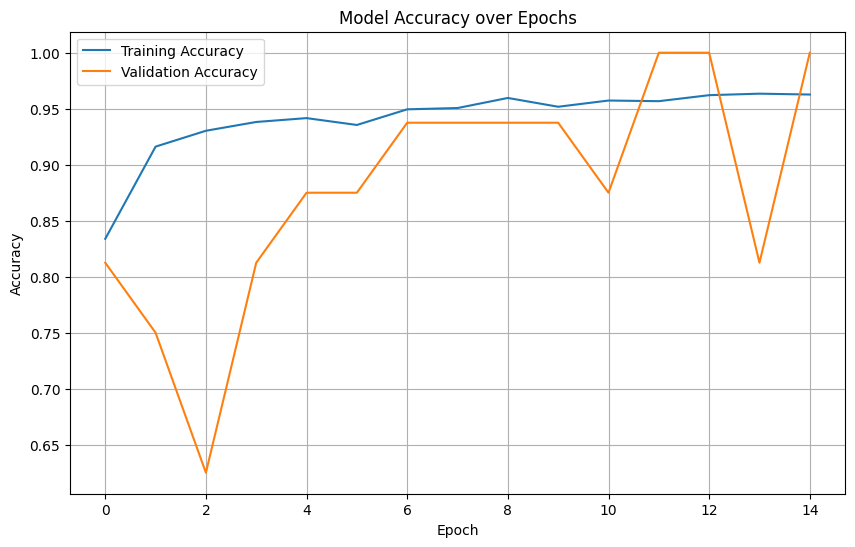

In [ ]:
import matplotlib.pyplot as plt

# Plot model accuracy graph
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))

    # Plot training & validation accuracy values
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Call the function to plot accuracy
plot_accuracy(history)
